# Neural Encoding Dataset | Synthetic EEG Data Tutorial


In this tutorial you will familiarize with the synthetic EEG responses of the [Neural Encoding Dataset (NED)][ned]. This tutorial is also available on [Colab][colab].

We generated the synthetic EEG responses using encoding models trained on [THINGS EEG 2][things_eeg] ([Gifford et al., 2022][gifford]), a large-scale dataset of EEG responses from 10 subjects who each viewed 16,740 images of objects on natural backgrounds. We trained transformer-based ([Dosovitskiy et al., 2020][dosovitskiy]) linearizing encoding models ([Naselaris et al., 2011][naselaris]) on all 10 subjects, and used them to synthesize EEG responses for the:
* 73,000 [NSD][nsd] images ([Allen et al., 2022][allen]);
* 50,000 [ILSVRC-2012 validation][imagenet] images ([Russakovsky et al., 2015][russakovsky]);
* 26,107 [THINGS initiative][things] images ([Hebart et al., 2019][hebart]).

For more information on NED, please refer to the [data manual][data_manual]. The code used to create NED (e.g., encoding models training, evaluation and deployment), along with utility functions (e.g., to use the NED's trained models to generate neural responses for any image of your choice), is available on [GitHub][github].

If you experience problems with the code please get in touch with Ale (alessandro.gifford@gmail.com).

If you use the code and/or data of this tutorial, please cite:

* (Gifford et al., 2024) --> coming soon!

[ned]: https://drive.google.com/drive/folders/1flyZw95cZGBTbePByWUKN6JQz1j1HoYh?usp=drive_link
[colab]: https://colab.research.google.com/drive/10NSRBrJ390vuaPyRWq5fDBIA4NNAUlTk?usp=drive_link
[things_eeg]: https://osf.io/3jk45/
[gifford]: https://www.sciencedirect.com/science/article/pii/S1053811922008758
[nsd]: https://naturalscenesdataset.org/
[allen]: https://doi.org/10.1038/s41593-021-00962-x
[imagenet]: https://www.image-net.org/challenges/LSVRC/2012/index.php
[russakovsky]: https://doi.org/10.1007/s11263-015-0816-y
[things]: https://things-initiative.org/
[hebart]: https://doi.org/10.1371/journal.pone.0223792
[imagenet]: https://www.image-net.org/challenges/LSVRC/2012/index.php#
[dosovitskiy]: https://arxiv.org/abs/2010.11929
[naselaris]: https://doi.org/10.1016/j.neuroimage.2010.07.073
[ned_paper]: !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
[data_manual]: https://docs.google.com/document/d/1DeQwjq96pTkPEnqv7V6q9g_NTHCjc6aYr6y3wPlwgDE/edit?usp=drive_link
[github]: https://github.com/gifale95/neural_encoding_dataset

# 0 | Configuration

## 0.1 | Install and import the necessary Python libraries

### 0.1.1 | Install libraries

If you are running the tutorial on Jupyter Notebook, you need to install the following libraries on your local machine before running the tutorial: [numpy][numpy], [h5py][h5py], [tqdm][tqdm], [pillow][pil], [torchvision][torchvision], [matplotlib][matplotlib], [jupyter][jupyter], [scikit-learn][sklearn].

[numpy]: https://numpy.org/
[pil]: https://pypi.org/project/pillow/
[h5py]: https://docs.h5py.org/en/stable/
[tqdm]: https://tqdm.github.io/
[torchvision]: https://pytorch.org/vision/stable/index.html
[matplotlib]: https://matplotlib.org/stable/index.html
[jupyter]: https://jupyter.org/
[sklearn]: https://scikit-learn.org/stable/

### 0.1.2 | Import the libraries

Once you have installed all necessary libraries, import them with the following code.

In [ ]:
import os
import numpy as np
import h5py
from tqdm import tqdm
from PIL import Image
import torchvision
from torchvision import transforms as trn
import matplotlib
from matplotlib import pyplot as plt
from sklearn.svm import SVC

## 0.2 | Access the data

If you are running the tutorial on Jupyter Notebook you first need to download the data from the public Google Drive folder [`neural_encoding_dataset`][data].

Then edit the `ned_dir` variable below with the path to the downloaded and unzipped data folder.

[data]: https://drive.google.com/drive/folders/1flyZw95cZGBTbePByWUKN6JQz1j1HoYh?usp=drive_link

In [ ]:
ned_dir = '../neural_encoding_dataset'

# 1 | Load and visualize the data

## 1.1 | Data selection

Here you can choose the subject and imageset of the synthetic EEG responses.

In [ ]:
# Choose subject
sub = 1 # options --> [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
print('Subject: ' + str(sub))

# Choose imageset
imageset = "nsd" # options --> ['nsd', 'imagenet_val', 'things']
print('Imageset: ' + imageset)

Subject: 1
Imageset: nsd


## 1.2 | Load the synthetic EEG responses

Now you will load and visualize the synthetic EEG responses.

The synthetic EEG responses are stored in the files (`synthetic_neural_responses_training_dataset-things_eeg_2_model-vit_b_32_imageset-*_sub-*.h5`), and consist in a 4-D array of shape (N images × N repeats × N EEG channels × N EEG time points).

The repeats dimension comes from the fact that, when training the encoding models, we split the EEG training data into 4 partitions, and trained a separate encoding model on each partition. Specifically, the whole training data consisted in EEG responses for 16,540 images, each repeated 4 times, which we split into 4 partitions across the repetitions dimension. This resulted in 4 encoding models, trained on non-overlapping EEG responses, and therefore in 4 instances (i.e., repeats) of synthetic neural responses.

<font color='red'><b>NOTE:</b></font> **Since the EEG encoding models implement a linear transformation from model features to EEG responses, averaging the 4 synthetic neural response instances (i.e., repeats) is numerically equivalent to the synthetic neural response of an encoding model trained using the whole EEG training data.**

The files (`synthetic_neural_responses_metadata_training_dataset-things_eeg_2_model-vit_b_32_imageset-*_sub-*.npy`) contain metadata related to the synthetic EEG responses.



In [ ]:
# Load the synthetic EEG data
data_dir = os.path.join(ned_dir, 'dataset', 'modality-eeg',
    'training_dataset-things_eeg_2', 'model-vit_b_32',
    'synthetic_neural_responses', 'imageset-'+imageset)
file_name = 'synthetic_neural_responses_training_dataset-things_eeg_2_' + \
    'model-vit_b_32_imageset-' + imageset + '_sub-' + format(sub, '02') + '.h5'
data = h5py.File(os.path.join(data_dir, file_name),
    'r').get('synthetic_neural_responses')

# Load the synthetic EEG metadata
file_name = 'synthetic_neural_responses_metadata_training_dataset-' + \
    'things_eeg_2_model-vit_b_32_imageset-' + imageset + '_sub-' + \
    format(sub, '02') + '.npy'
metadata = np.load(os.path.join(data_dir, file_name), allow_pickle=True).item()

# Visualize the synthetic EEG data dimensions
print('Synthetic EEG data shape:')
print(data.shape)
print('(Images × Repeats × EEG channels × EEG time points)')

print('\nEEG channels:')
for c, chan in enumerate(metadata['eeg']['ch_names']):
    print(c, chan)

print('\nEEG time points (in seconds):')
for t, time in enumerate(metadata['eeg']['times']):
    print(t, np.round(time, decimals=3))

Synthetic EEG data shape:
(73000, 4, 63, 140)
(Images × Repeats × EEG channels × EEG time points)

EEG channels:
0 Fp1
1 F3
2 F7
3 FT9
4 FC5
5 FC1
6 C3
7 T7
8 TP9
9 CP5
10 CP1
11 Pz
12 P3
13 P7
14 O1
15 Oz
16 O2
17 P4
18 P8
19 TP10
20 CP6
21 CP2
22 Cz
23 C4
24 T8
25 FT10
26 FC6
27 FC2
28 F4
29 F8
30 Fp2
31 AF7
32 AF3
33 AFz
34 F1
35 F5
36 FT7
37 FC3
38 FCz
39 C1
40 C5
41 TP7
42 CP3
43 P1
44 P5
45 PO7
46 PO3
47 POz
48 PO4
49 PO8
50 P6
51 P2
52 CPz
53 CP4
54 TP8
55 C6
56 C2
57 FC4
58 FT8
59 F6
60 F2
61 AF4
62 AF8

EEG time points (in seconds):
0 -0.1
1 -0.095
2 -0.09
3 -0.085
4 -0.08
5 -0.075
6 -0.07
7 -0.065
8 -0.06
9 -0.055
10 -0.05
11 -0.045
12 -0.04
13 -0.035
14 -0.03
15 -0.025
16 -0.02
17 -0.015
18 -0.01
19 -0.005
20 0.0
21 0.005
22 0.01
23 0.015
24 0.02
25 0.025
26 0.03
27 0.035
28 0.04
29 0.045
30 0.05
31 0.055
32 0.06
33 0.065
34 0.07
35 0.075
36 0.08
37 0.085
38 0.09
39 0.095
40 0.1
41 0.105
42 0.11
43 0.115
44 0.12
45 0.125
46 0.13
47 0.135
48 0.14
49 0.145
50 0.15
51 0.155
52 

## 1.3 | EEG channel selection

EEG channels can be grouped based on their position (e.g., occipital, parietal, temporal, central, frontal). You can choose whether to use all of the EEG channels, or only the ones coming from a specific channel group.

In [ ]:
# Choose the EEG channels to keep
kept_channels = "occipital" # options --> ['occipital', 'parietal', 'temporal', 'central', 'frontal', 'all']

# Channels selection
if kept_channels != 'all':
	ch_names_kept = []
	idx_ch = []
	for c, chan in enumerate(metadata['eeg']['ch_names']):
		if kept_channels[0].upper() in chan:
			ch_names_kept.append(chan)
			idx_ch.append(c)
	idx_ch = np.asarray(idx_ch)
elif kept_channels == 'all':
	ch_names_kept = metadata['eeg']['ch_names']
	idx_ch = np.arange(0, len(metadata['eeg']['ch_names']))

# Visualize the new synthetic EEG data dimensions
print('New synthetic EEG data shape (image 1, repeat 1):')
print(data[0,0,idx_ch].shape)
print('(EEG channels × EEG time points)')

print('\nKept EEG channels:')
for c, chan in enumerate(ch_names_kept):
    print(c, chan)

New synthetic EEG data shape (image 1, repeat 1):
(8, 140)
(EEG channels × EEG time points)

Kept EEG channels:
0 O1
1 Oz
2 O2
3 PO7
4 PO3
5 POz
6 PO4
7 PO8


## 1.4 | Link the synthetic EEG responses to the corresponding images

Here you will match the synthetic EEG responses to the corresponding images. You will start by accessing the imagesets. Since the NSD, ILSVRC-2012, and THINGS imagesets are organized differently, you will access each of them in a different way.

In [ ]:
# Access the imagesets
if imageset == 'nsd':
    imageset_dir = os.path.join(ned_dir, 'imagesets', 'imageset-nsd',
        'nsd_stimuli.hdf5')
    images = h5py.File(imageset_dir, 'r')
    images = images.get('imgBrick')
elif imageset == 'imagenet_val':
    imageset_dir = os.path.join(ned_dir, 'imagesets', 'imageset-imagenet_val')
    images = torchvision.datasets.ImageNet(root=imageset_dir, split='val')
elif imageset == 'things':
    images = metadata['things_labels']['image_paths']

Here you can choose an image (indexing is zero-based), and link it to the corresponding synthetic EEG response.

In [ ]:
# Choose the image
if imageset == 'nsd':
    nsd_img = 0 # options --> range(0, 73000)
    img_idx = nsd_img
elif imageset == 'imagenet_val':
    imagenet_img = 0 # options --> range(0, 50000)
    img_idx = imagenet_img
elif imageset == 'things':
    things_img = 0 # options --> range(0, 26107)
    img_idx = things_img

# Link the image to the corresponding synthetic EEG response
eeg_response = data[img_idx,:,idx_ch]
print('Synthetic EEG image response shape:')
print(eeg_response.shape)
print('(Repeats × EEG channels × EEG time points)')

Synthetic EEG image response shape:
(4, 8, 140)
(Repeats × EEG channels × EEG time points)


And now you will load and visualize the image you chose, along with optional metadata (e.g., image category).

Since the ILSVRC-2012 images are rectangular, we center cropped them to square format prior to feeding them to encoding models to synthesize their corresponding EEG responses. Here you will apply the same center cropping when loading these images. The NSD and THINGS images are already in square format, and therefore don't need any cropping.

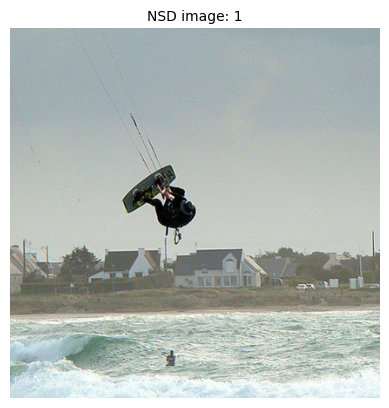

In [ ]:
# Load the selected image
if imageset == 'nsd':
    img = images[img_idx]
elif imageset == 'imagenet_val':
    img, _ = images.__getitem__(img_idx)
    transform = trn.Compose([trn.CenterCrop(min(img.size))])
    img = transform(img)
elif imageset == 'things':
    img_dir = os.path.join(ned_dir, 'imagesets', 'imageset-things',
        images[img_idx])
    img = Image.open(img_dir).convert('RGB')

# Visualize the image (along with optional metadata)
plt.figure()
plt.axis('off')
plt.imshow(img)
if imageset == 'nsd':
    title = 'NSD image: ' + str(img_idx+1)
elif imageset == 'imagenet_val':
    label_number = metadata['imagenet_val_labels']['label_number'][img_idx]
    label_name = metadata['imagenet_val_labels']['label_names'][label_number]
    title = 'ILSVRC-2012 validation image: ' + str(img_idx+1) + \
        '\nCategory number: ' + str(label_number+1) + \
        '\nCategory name: ' + label_name
elif imageset == 'things':
    object_concept_number = \
        metadata['things_labels']['image_concept_index'][img_idx]
    object_concept_name = \
        metadata['things_labels']['unique_id'][object_concept_number]
    file_name = \
        metadata['things_labels']['image_paths'][img_idx]
    title = 'THINGS image: ' + str(img_idx+1) + \
        '\nObject concept number: ' + str(object_concept_number+1) + \
        '\nObject concept name: ' + object_concept_name + \
        '\nFile name: ' + file_name
plt.title(title, fontsize=10);

## 1.5 | Plot the encoding models prediction accuracy

For each THINGS EEG 2 subject, we trained the encoding models using 16,540 images, and tested them on 200 images. We used the trained encoding models to synthesize the EEG responses for the 200 test images, and compared these synthetic responses to the ground truth (real) EEG responses through a Pearson correlation. We correlated ground-truth and synthetic EEG responses independently for each EEG channel and time point (across the 200 test images), resulting in a prediction accuracy score for each channel and time point.

Here you will plot the prediction accuracy averaged across the EEG channels from the channel group chosen above, against the (split-half) noise ceiling lower and upper bounds (denoted by the gray region).

Since there are 4 instances of synthetic EEG responses you will plot the correlation score of the ground truth EEG response against each single synthetic EEG instance (black dashed lines), as well as the correlation score of the ground truth EEG response against the average over the 4 synthetic EEG instances (pink solid line).

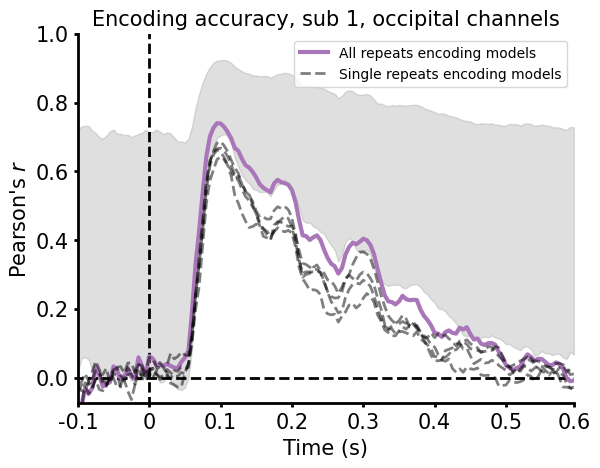

In [ ]:
# Get the encoding accuracy results
encoding_acc_all_rep = np.mean(metadata['encoding_models']['encoding_accuracy']\
    ['correlation_all_repetitions'][idx_ch], 0)
encoding_acc_single_rep = np.mean(metadata['encoding_models']\
    ['encoding_accuracy']['correlation_single_repetitions'][:,idx_ch], 1)
noise_ceiling_low = np.mean(metadata['encoding_models']['encoding_accuracy']\
    ['noise_ceiling_lower'][idx_ch], 0)
noise_ceiling_up = np.mean(metadata['encoding_models']['encoding_accuracy']\
    ['noise_ceiling_upper'][idx_ch], 0)
times = metadata['eeg']['times']

# Plot parameters
fontsize = 15
matplotlib.rcParams['font.sans-serif'] = 'DejaVu Sans'
matplotlib.rcParams['font.size'] = fontsize
plt.rc('xtick', labelsize=fontsize)
plt.rc('ytick', labelsize=fontsize)
matplotlib.rcParams['axes.linewidth'] = 2
matplotlib.rcParams['xtick.major.width'] = 2
matplotlib.rcParams['xtick.major.size'] = 3
matplotlib.rcParams['ytick.major.width'] = 2
matplotlib.rcParams['ytick.major.size'] = 3
matplotlib.rcParams['axes.spines.left'] = True
matplotlib.rcParams['axes.spines.bottom'] = True
matplotlib.rcParams['axes.spines.right'] = False
matplotlib.rcParams['axes.spines.top'] = False
matplotlib.rcParams['lines.markersize'] = 3
colors = [(170/255, 118/255, 186/255)]
color_noise_ceiling = (150/255, 150/255, 150/255)

# Plot the channel-average encoding accuracy
plt.plot()
plt.plot([-10, 10], [0, 0], 'k--', [0, 0], [100, -100], 'k--', linewidth=2,
    label='_nolegend_')
plt.fill_between(times, noise_ceiling_low, noise_ceiling_up,
    color=color_noise_ceiling, alpha=.3, label='_nolegend_')
plt.plot(times, encoding_acc_all_rep, color=colors[0], linewidth=3,
    label='All repeats encoding models')
for r, res in enumerate(encoding_acc_single_rep):
    if r == 0:
        plt.plot(times, res, '--', color='k', linewidth=2, alpha=0.5,
            label='Single repeats encoding models')
    else:
        plt.plot(times, res, '--', color='k', linewidth=2, alpha=0.5,
            label='_nolegend_')
plt.ylabel('Pearson\'s $r$', fontsize=fontsize)
plt.ylim(bottom=-.075, top=1)
plt.xlabel('Time (s)', fontsize=fontsize)
xticks = [-0.1, 0, .1, .2, .3, .4, .5, times[-1]]
xlabels = [-0.1, 0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6]
plt.xticks(ticks=xticks, labels=xlabels)
plt.xlim(left=min(times), right=max(times));
title = 'Encoding accuracy, sub ' +str(sub) + ', ' + kept_channels + ' channels'
plt.title(title, fontsize=fontsize)
plt.legend(fontsize=fontsize-5);

# 2 | Data quality check

## 2.1 | Pairwise decoding

Here you will quantitatively evaluate the visual information present in the synthetic EEG responses through pairwise decoding. Pairwise decoding is a commonly used method in computational neuroscience which exploits similar information present between the repeats of each image condition to classify neural data ([Haynes and Rees, 2006][haynes]; [Mur et al., 2009][mur]).

You will train linear support vector machines (SVMs) to perform binary classification between each pair of image conditions using 3-out-of-4 repeats, and then tested the trained SVMs on the left out repeat (until every repeat is left out once). The analysis is performed independently for each EEG time point, and at each time point, the SVM trains using the information contained in the different EEG channels. This will result in a symmetric 2-D results array of shape (Images × Images), for each EEG time point, where each array entry indicates how well the EEG responses from two image conditions could be decoded (i.e, differentiated) at any given time point (since this is a binary choice, chance level is 50%). Finally, you will average the lower (or upper) triangular entries, resulting in the temporal course of synthetic EEG response image decoding.

[haynes]: https://doi.org/10.1038/nrn1931
[mur]: https://doi.org/10.1093/scan/nsn044

To reduce computational load, you will begin by selecting 50 image conditions you will use for the pairwise decoding, through the following selection scheme:
* **NSD synthetic EEG response:** 50 out of the 1000 NSD shared images (the 1000 images that all subjects saw).
* **ImageNet synthetic EEG response:** 50 images, each coming from one of the 1000 object categories.
* **THINGS synthetic EEG response:** the first 50 test image conditions from the THINGS EEG 2 dataset.

In [ ]:
# Select the NSD image conditions
if imageset == 'nsd':
    img_idx = metadata['nsd_labels']['subjectim'][0,:50]

# Select the ImageNet image conditions
elif imageset == 'imagenet_val':
    img_idx = np.arange(0, 50000, 50)[:50]

# Select the THINGS image conditions
elif imageset == 'things':
    image_paths = metadata['things_labels']['image_paths']
    image_metadata = metadata['encoding_models']['train_test_things_image_splits']
    img_idx = []
    idx = 0
    for i, path in enumerate(image_paths.values()):
        if len(img_idx) < len(image_metadata['test_img_concepts']):
            fname = 'images/' + image_metadata['test_img_concepts'][idx][6:] + \
                '/' + image_metadata['test_img_files'][idx]
            if path == fname:
                img_idx.append(i)
                idx += 1
    img_idx = np.asarray(img_idx)[:50]

# Read the EEG data into memory
decoding_data = data[img_idx,:]
decoding_data = decoding_data[:,:,idx_ch]

Now you will perform pairwise decoding on the synthetic EEG responses for the selected images.

In [ ]:
# Results array of shape:
# (Image conditions x Image conditions x EEG times)
pairwise_decoding = np.zeros((len(decoding_data), len(decoding_data),
    len(times)))

# Loop over EEG time, image conditions and EEG repetitions
for t in tqdm(range(len(times))):
    for i1 in range(len(decoding_data)):
        for i2 in range(i1):
            # Select the image condition data
            eeg_cond_1 = decoding_data[i1,:,:,t]
            eeg_cond_2 = decoding_data[i2,:,:,t]
            # SVM target vectors
            y_train = np.zeros(((len(eeg_cond_1)-1)*2))
            y_train[int(len(y_train)/2):] = 1
            y_test = np.asarray((0, 1))
            scores = np.zeros(len(eeg_cond_1))
            for r in range(len(eeg_cond_1)):
                # Define the training/test partitions
                X_train = np.append(np.delete(eeg_cond_1, r, 0),
                    np.delete(eeg_cond_2, r, 0), 0)
                X_test = np.append(np.expand_dims(eeg_cond_1[r], 0),
                    np.expand_dims(eeg_cond_2[r], 0), 0)
                # Train the classifier
                dec_svm = SVC(kernel='linear')
                dec_svm.fit(X_train, y_train)
                # Test the classifier
                y_pred = dec_svm.predict(X_test)
                scores[r] = sum(y_pred == y_test) / len(y_test)
            # Store the accuracy
            pairwise_decoding[i1,i2,t] = np.mean(scores)
            pairwise_decoding[i2,i1,t] = pairwise_decoding[i1,i2,t]

# Average the decoding accuracies across pairwise comparisons
idx_tril = np.tril_indices(len(decoding_data), -1)
pairwise_decoding = np.mean(pairwise_decoding[idx_tril], 0) * 100

100%|██████████| 140/140 [12:48<00:00,  5.49s/it]


Finally, here you will plot the decoding accuracy time course.

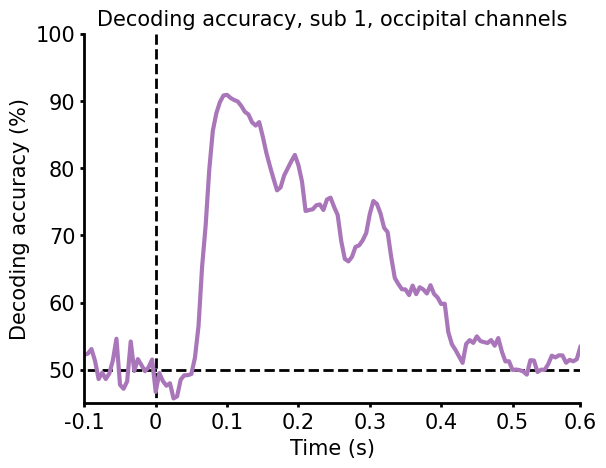

In [ ]:
# Plot the pairwise decoding results
plt.plot()
plt.plot([-10, 10], [50, 50], 'k--', [0, 0], [100, -100], 'k--', linewidth=2)
plt.plot(times, pairwise_decoding, color=colors[0], linewidth=3)
plt.ylabel('Decoding accuracy (%)', fontsize=fontsize)
plt.ylim(bottom=45, top=100)
plt.xlabel('Time (s)', fontsize=fontsize)
xticks = [-0.1, 0, .1, .2, .3, .4, .5, times[-1]]
xlabels = [-0.1, 0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6]
plt.xticks(ticks=xticks, labels=xlabels)
plt.xlim(left=min(times), right=max(times));
title = 'Decoding accuracy, sub ' +str(sub) + ', ' + kept_channels + ' channels'
plt.title(title, fontsize=fontsize);